In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


In [2]:
data = yf.download('AAPL', start='2015-01-01', end='2024-12-31')


/tmp/ipykernel_13/3410338993.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('AAPL', start='2015-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed


In [3]:
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['STD_20'] = data['Close'].rolling(window=20).std()

# RSI (Relative Strength Index) 14-day
data['RSI_14'] = 100 - (100 / (1 + data['Close'].pct_change().rolling(14).apply(
    lambda x: (x[x > 0].mean() / abs(x[x < 0].mean())) if abs(x[x < 0].mean()) != 0 else 0)))


In [4]:
data['Target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)
data.dropna(inplace=True)


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [5]:
X = data[['Close', 'SMA_10', 'SMA_50', 'STD_20', 'RSI_14']]
y = data['Target']

# Flatten MultiIndex columns if any
if isinstance(X.columns, pd.MultiIndex):
    X.columns = ['_'.join(col).strip() for col in X.columns.values]


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [7]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [8]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.46153846153846156

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.94      0.61       217
           1       0.66      0.08      0.15       277

    accuracy                           0.46       494
   macro avg       0.55      0.51      0.38       494
weighted avg       0.56      0.46      0.35       494



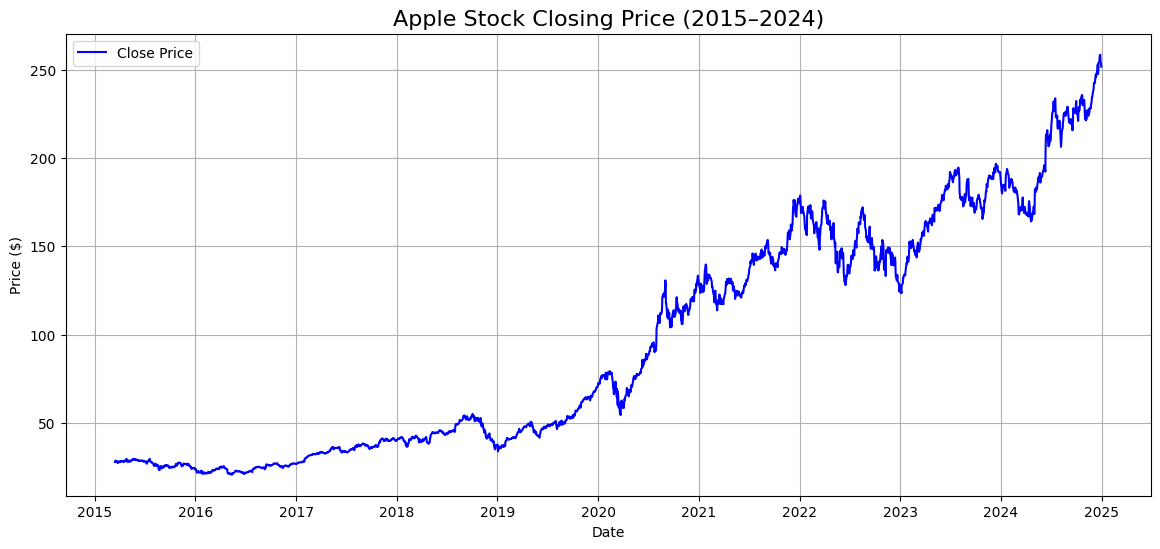

In [9]:
# Plot closing prices
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['Close'], label='Close Price', color='blue')
plt.title('Apple Stock Closing Price (2015–2024)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()


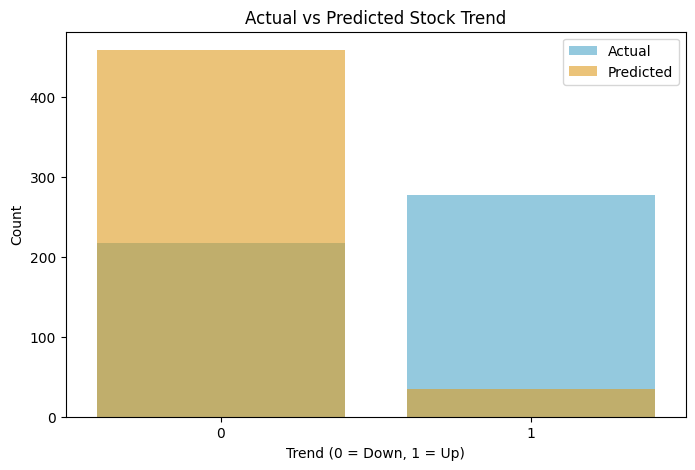

In [10]:
# Plot prediction vs actual
plt.figure(figsize=(8, 5))
sns.countplot(x=y_test, label='Actual', color='skyblue')
sns.countplot(x=y_pred, label='Predicted', color='orange', alpha=0.6)
plt.title("Actual vs Predicted Stock Trend")
plt.xlabel("Trend (0 = Down, 1 = Up)")
plt.ylabel("Count")
plt.legend()
plt.show()


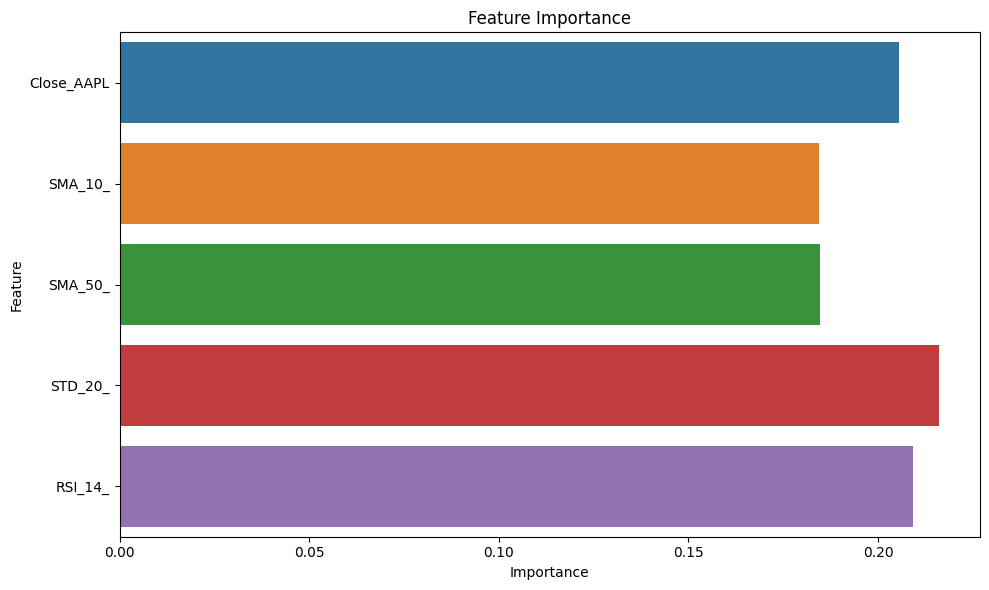

In [11]:
importances = model.feature_importances_

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=X.columns)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
